# Hidden Markov Models with Gaussian Emissions

List of tasks performed in this notebook:
- Implement the algorithms for the evaluation and decoding of Hidden Markov Models
- Use the implementation to perform isolated word recognition
- Implement the algorithms for training Gaussian Hidden Markov Models (G-HMMs)
- Explain the meaning of the forward, backward and state posterior probabilities evaluated on speech utterances

Authors:
* Damian Valle
* Marc Botet


## Imports and data loading

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

phoneHMMs_one = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [ ]:
example.keys()

dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma'])

## Tools

In [ ]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

isolated = {}
for digit in prondict.keys():
  isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [ ]:
def logsumexp(arr, axis=0):
    """Computes the sum of arr assuming arr is in the log domain.
    Returns log(sum(exp(arr))) while minimizing the possibility of
    over/underflow.
    """
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    if vmax.ndim > 0:
        vmax[~np.isfinite(vmax)] = 0
    elif not np.isfinite(vmax):
        vmax = 0
    with np.errstate(divide="ignore"):
        out = np.log(np.sum(np.exp(arr - vmax), axis=0))
        out += vmax
        return out

def log_multivariate_normal_density_diag(X, means, covars):
    """Compute Gaussian log-density at X for a diagonal model

    Args:
        X: array like, shape (n_observations, n_features)
        means: array like, shape (n_components, n_features)
        covars: array like, shape (n_components, n_features)

    Output:
        lpr: array like, shape (n_observations, n_components)
    From scikit-learn/sklearn/mixture/gmm.py
    """
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr

## Functions

In [ ]:
def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """

    ans = {}
    
    K = hmm1['means'].shape[0] + hmm2['means'].shape[0]
    
    ans['name'] = hmm1['name'] + hmm2['name']
    ans['startprob'] = np.zeros((K+1, 1))
    ans['transmat'] = np.zeros((K+1, K+1))
    ans['means'] = np.vstack((hmm1['means'], hmm2['means']))
    ans['covars'] = np.vstack((hmm1['covars'], hmm2['covars']))
    
    start1 = hmm1['startprob'].reshape(-1,1)
    start2 = hmm2['startprob'].reshape(-1,1)
    
    ans['startprob'][:hmm1['startprob'].shape[0]-1,:] = start1[:-1,:]
    ans['startprob'][hmm1['startprob'].shape[0]-1:,:] = np.dot(start1[-1,0], start2)
    trans = ans['transmat']
    trans1 = hmm1['transmat']
    trans2 = hmm2['transmat']

    trans[:trans1.shape[0]-1,:trans1.shape[1]-1] = trans1[:-1,:-1]
    temp = trans1[:-1,-1].reshape(-1,1)
    trans[:trans1.shape[0]-1,trans1.shape[1]-1:] = np.dot(temp,start2.T)
    trans[trans1.shape[0]-1:,trans1.shape[1]-1:] = trans2
    ans['transmat'] = trans    
    
    return ans

In [ ]:
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    
    concat = hmmmodels[namelist[0]]
    for idx in range(1, len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [ ]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    alpha = np.zeros(log_emlik.shape)
    alpha[0][:] = log_startprob.T + log_emlik[0]

    for n in range(1,len(alpha)):
        for i in range(alpha.shape[1]):
            alpha[n, i] = logsumexp(alpha[n - 1] + log_transmat[:,i]) + log_emlik[n,i]
    return alpha

In [ ]:
def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """
    N, M = log_emlik.shape
    beta = np.zeros((N,M))
    for n in reversed(range(N-1)):
        for i in range(M):
            beta[n,i] = logsumexp(log_transmat[i,:] + log_emlik[n+1,:] + beta[n+1,:])
    return beta

In [ ]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    #N, M = log_emlik.shape[0], log_emlik.shape[1]
    N = log_emlik.shape[0]
    M = log_emlik.shape[1]

    V = np.zeros((N,M))
    B = np.zeros((N,M))
    viterbi_path = np.zeros((N), dtype=np.int)
    viterbi_loglik = 0

    for j in range(M):
      V[0, j] = log_startprob[j] + log_emlik[0,j]

    for n in range(1,N):
      for j in range(M):
        V[n, j] = np.max(V[n-1,:] + log_transmat[:,j]) + log_emlik[n,j]
        B[n, j] = np.argmax(V[n-1,:] + log_transmat[:,j])

    viterbi_path[-1] = np.argmax(V[-1, :])
    viterbi_loglik = V[N-1, viterbi_path[-1]]

    for n in range(0,N-1):
      viterbi_path[n] += np.max(V[n-1,:])

    for n in reversed(range(N-1)):
      for j in range(M):
        viterbi_path[n] = B[n+1, viterbi_path[n+1]]
            
    return (viterbi_loglik, viterbi_path)

In [ ]:
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    N, M = log_alpha.shape
    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[N - 1])
    return log_gamma

In [ ]:
def statePosteriorsGMM(log_emlik):

  denom = logsumexp(log_emlik)
  gammas = log_emlik - denom

  return gammas

In [ ]:
def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """

    gamma = np.exp(log_gamma)
    n_state = gamma.shape[1]
    n_feat = X.shape[1]

    means = np.zeros((n_state, n_feat))
    covars = np.zeros_like(means)

    for i in range(n_state):
      gamma_denom = np.sum(gamma[:,i])
      means[i] = np.sum(gamma[:,i].reshape(-1, 1) * X, axis = 0) / gamma_denom
      covars[i] = np.sum(gamma[:,i].reshape(-1, 1) * (X - means[i])**2, axis = 0) / gamma_denom

    np.clip(covars, varianceFloor, None, covars)

    return means, covars

## HMM Likelihood and Recognition

In [ ]:
isolated = {}
wordHMMs = {}
for digit in prondict.keys():
  isolated[digit] = ['sil'] + prondict[digit] + ['sil']
  wordHMMs[digit] = concatHMMs(phoneHMMs_one, isolated[digit])

### Gaussian Emission Probabilities

True


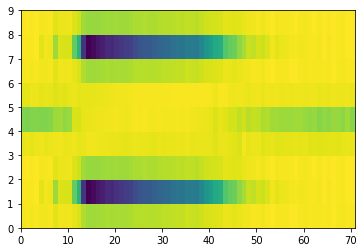

In [ ]:
answer = {}
digit = 'o'

answer['obsloglik'] = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars'])

print(np.allclose(example['obsloglik'], answer['obsloglik']))

plt.pcolormesh(answer['obsloglik'].T)
plt.show()

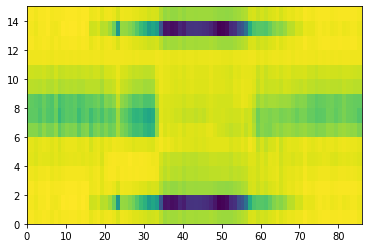

In [ ]:
answer = {}
digit = '4'

answer['obsloglik'] = log_multivariate_normal_density_diag(data[10]['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars'])

plt.pcolormesh(answer['obsloglik'].T)
plt.show()

### Forward algorithm

True


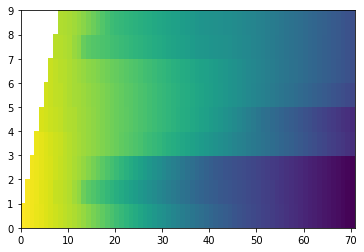

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

log_startprob = np.log(wordHMMs[digit]['startprob'][:-1])
log_transmat = np.log(wordHMMs[digit]['transmat'][:-1,:-1])
answer['logalpha'] = forward(example['obsloglik'], log_startprob, log_transmat)

print(np.allclose(example['logalpha'], answer['logalpha']))

plt.pcolormesh(example['logalpha'].T)
plt.show()

In [ ]:
answer['loglik'] = logsumexp(answer['logalpha'][-1])
print(example['loglik'] == answer['loglik'])

True


In [ ]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
  isolated[digit] = ['sil'] + prondict[digit] + ['sil']
  wordHMMs_all[digit] = concatHMMs(phoneHMMs, isolated[digit])

### Scoring models

In [ ]:
idx2digit = []
digit2idx = {}

for idx, digit in enumerate(prondict.keys()):
  idx2digit.append(digit)
  digit2idx[digit] = idx

In [ ]:
def forward_predict(wordHMMs):
    scores = np.zeros((44,11))
    ground_truth = []

    for idx1, utt in enumerate(data):
        ground_truth.append(digit2idx[utt['digit']])
        for idx2, word in enumerate(wordHMMs):
            answer['obsloglik'] = log_multivariate_normal_density_diag(utt['lmfcc'], wordHMMs[word]['means'], wordHMMs[word]['covars'])  
            log_startprob = np.log(wordHMMs[word]['startprob'][:-1])
            log_transmat = np.log(wordHMMs[word]['transmat'][:-1,:-1])
            alpha = forward(answer['obsloglik'], log_startprob, log_transmat)
            answer['loglik'] = logsumexp(alpha[-1])
            scores[idx1, idx2] = answer['loglik']

    return accuracy_score(np.argmax(scores, axis=1), ground_truth)

In [ ]:
%time acc_all = forward_predict(wordHMMs_all)

CPU times: user 24.6 s, sys: 1.17 s, total: 25.7 s
Wall time: 24.3 s


In [ ]:
%time acc_one = forward_predict(wordHMMs)

CPU times: user 24.3 s, sys: 1.17 s, total: 25.4 s
Wall time: 24 s


In [ ]:
print('Accuracy for one speaker model:  {:.2f}'.format(acc_one))
print('Accuracy for all speakers model: {:.2f}'.format(acc_all))

Accuracy for one speaker model:  0.77
Accuracy for all speakers model: 0.98


### Viterbi

In [ ]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(obsloglik, log_startprob, log_transmat) 
answer['vloglik'], answer['vpath'] = viterbi(obsloglik, log_startprob, log_transmat)

In [ ]:
print(np.allclose(answer['vloglik'], example['vloglik']))
print(np.allclose(answer['vpath'], example['vpath']))

True
True


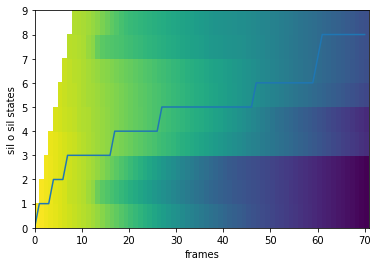

In [ ]:
plt.pcolormesh(alpha.T)
plt.plot(answer['vpath'])
plt.xlabel('frames')
plt.ylabel('sil o sil states')
plt.show()

In [ ]:
def viterbi_predict(wordHMMs):
    scores = np.zeros((44,11))
    ground_truth = []

    for idx1, utt in enumerate(data):
        ground_truth.append(digit2idx[utt['digit']])
        for idx2, word in enumerate(wordHMMs):
            obsloglik = log_multivariate_normal_density_diag(utt['lmfcc'], wordHMMs[word]['means'], wordHMMs[word]['covars'])  
            log_startprob = np.log(wordHMMs[word]['startprob'][:-1])
            log_transmat = np.log(wordHMMs[word]['transmat'][:-1,:-1])
            vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)
            scores[idx1, idx2] = vloglik

    return accuracy_score(np.argmax(scores, axis=1), ground_truth)

In [ ]:
%time acc_all = viterbi_predict(wordHMMs_all)

CPU times: user 9.76 s, sys: 615 ms, total: 10.4 s
Wall time: 9.75 s


In [ ]:
%time acc_one = viterbi_predict(wordHMMs)

CPU times: user 9.48 s, sys: 385 ms, total: 9.87 s
Wall time: 9.47 s


In [ ]:
print('Accuracy for one speaker model:  {:.2f}'.format(acc_one))
print('Accuracy for all speakers model: {:.2f}'.format(acc_all))

Accuracy for one speaker model:  0.77
Accuracy for all speakers model: 1.00


### Backward pass

In [ ]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
beta = backward(obsloglik, log_startprob, log_transmat)

True


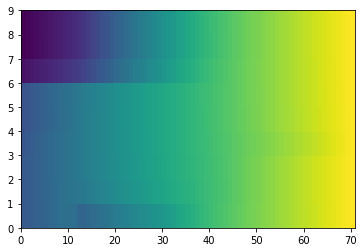

In [ ]:
print(np.allclose(example['logbeta'], beta))
plt.pcolormesh(beta.T)
plt.show()

## HMM Retraining

In [ ]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
log_alpha = forward(obsloglik, log_startprob, log_transmat) 
log_beta = backward(obsloglik, log_startprob, log_transmat)
log_gamma = statePosteriors(alpha, beta)

In [ ]:
print(np.allclose(example['loggamma'], log_gamma))
np.allclose(np.sum(np.exp(log_gamma), axis = 1), np.ones(log_gamma.shape[0]))

True


True

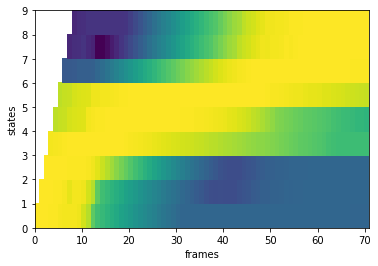

In [ ]:
plt.pcolormesh(log_gamma.T)
plt.xlabel('frames')
plt.ylabel('states')
plt.show()

In [ ]:
gmm_gammas = statePosteriorsGMM(obsloglik)

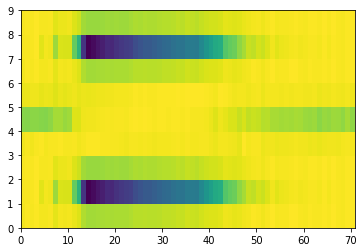

In [ ]:
plt.pcolormesh(gmm_gammas.T)
plt.show()

### Summing HMM posteriors

In [ ]:
gamma = np.exp(log_gamma)

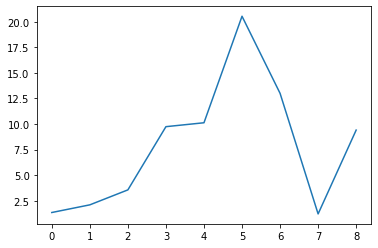

In [ ]:
plt.plot(np.sum(gamma, axis=0))
plt.show()

In [ ]:
np.sum(gamma)

70.99999999991067

### Retraining the emission probability distributions

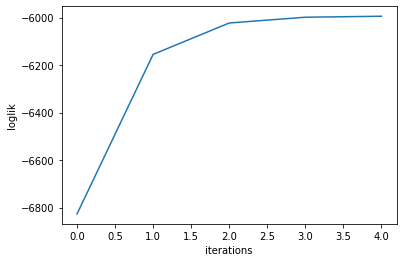

In [ ]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
  isolated[digit] = ['sil'] + prondict[digit] + ['sil']
  wordHMMs_all[digit] = concatHMMs(phoneHMMs, isolated[digit])

max_iters = 20
threshold = 1
loglik_evolution = []
digit = '4'

log_startprob = np.log(wordHMMs_all['4']['startprob'][:-1])
log_transmat =  np.log(wordHMMs_all['4']['transmat'][:-1,:-1])


for i in range(max_iters):
  obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], wordHMMs_all[digit]['means'], wordHMMs_all[digit]['covars'])

  alpha = forward(obsloglik, log_startprob, log_transmat) 
  beta = backward(obsloglik, log_startprob, log_transmat)
  log_gamma = statePosteriors(alpha, beta)
  loglik = logsumexp(alpha[-1])

  if i and loglik - loglik_evolution[-1] < threshold:
    break

  loglik_evolution.append(loglik)
  wordHMMs_all[digit]['means'], wordHMMs_all[digit]['covars'] = updateMeanAndVar(data[10]['lmfcc'], log_gamma)

plt.plot(loglik_evolution)
plt.xlabel('iterations')
plt.ylabel('loglik')
plt.show()

[-7041.542140050837, -6190.523823350007, -5996.860424783277, -5955.943696768653, -5928.814863143417, -5919.2712835662, -5914.647750120037, -5911.803921583841, -5905.8109884208125, -5903.338236248106]


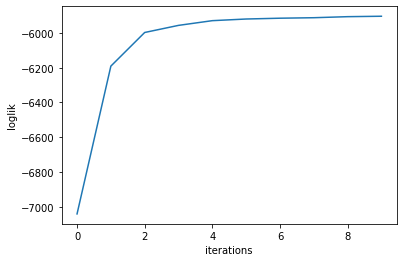

In [ ]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
  isolated[digit] = ['sil'] + prondict[digit] + ['sil']
  wordHMMs_all[digit] = concatHMMs(phoneHMMs, isolated[digit])

max_iters = 20
threshold = 1
loglik_evolution = []
digit = '1'

log_startprob = np.log(wordHMMs_all[digit]['startprob'][:-1])
log_transmat =  np.log(wordHMMs_all[digit]['transmat'][:-1,:-1])

for i in range(max_iters):
  obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], wordHMMs_all[digit]['means'], wordHMMs_all[digit]['covars'])

  alpha = forward(obsloglik, log_startprob, log_transmat) 
  beta = backward(obsloglik, log_startprob, log_transmat)
  log_gamma = statePosteriors(alpha, beta)
  loglik = logsumexp(alpha[-1])

  if i and loglik - loglik_evolution[-1] < threshold:
    break

  loglik_evolution.append(loglik)
  wordHMMs_all[digit]['means'], wordHMMs_all[digit]['covars'] = updateMeanAndVar(data[10]['lmfcc'], log_gamma)

print(loglik_evolution)
plt.plot(loglik_evolution)
plt.xlabel('iterations')
plt.ylabel('loglik')
plt.show()